In [1]:
import uproot
import awkward as ak
import succolib as sl
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from random import randint

In [2]:
# file names and path
# ---
# open test data with:
# treename = "t"
# filepath = "data_test/"
# filenames = [
#     "run" + "650272" + "_00000*.root",
#     "run" + "650272" + "_00001*.root",
# ]
# ---
treename = "t"
filepath = "data_test/"
filenames = [
    "run" + "650272" + "_00000*.root",
    "run" + "650272" + "_00001*.root",
]

# waveform channel map
ind_wave = {
    "Cal" : 1,
}

# fast analysis channel map relative to waveform channel map
ind_ph = ind_wave

# list of variables to open
# note: tracking data should be called "xRaw"
variables = [
    "xRaw",
    "wave"+str(ind_wave["Cal"]), 
]

# tracking info
trackingID = ((0, 2), (1, 3))  # IDs of the tracking modules to be used for tracking
dzT1T0 = 72.6  # distance between tracking planes
dzCalT1 = 89.9+8.5  # distance between downstream plane and detector under study
thxShift = 0.003993  # alignment of angular distribution, x
thyShift = 0.004169  # alignment of angular distribution, y

# waveform info
# ---
# > polPos
# > nBinsBase
# > bDigiTimeCalib
# > digiTimeCalib
# > bDigiSignalCalib
# > digiSignalCalib
# ---
wf_info = {
    "Cal" : {
        "polPos" : True,  # if False, reverse waveform polarity
        "nBinsBase" : 50,  # nr. of ticks at the beginning for baseline computation
        "bDigiTimeCalib" : True,  # calibrate the time ticks? ticks --> ns
        "digiTimeCalib" : (1/5e9)*1e9,  # in ns/ticks
        "bDigiSignalCalib" : True,  # calibrate the signal amplitude? ADC --> mV
        "digiSignalCalib" : (1/4096)*1000,  # in mV/ADC
        "upperLimWfVis" : 900,  # cut waveform visualisation with amplitude above this limit
    }
}

# distributions settings
rterm = 50  # in ohm
pllims = (-10, 220, -20, 1100)  # (t0 [ns], t1 [ns], V0 [mV], V1 [mV])
qtpllims = (0, 3000) # (Q0 [pC], Q1 [pC])
timecut_sig = (28, 64)  # in ns
phcut_sig = (-20000, 20000)  # in mV
timecut_bkg = (150, 200)  # in ns
phcut_bkg = (-20000, 20000)  # in mV

In [3]:
%%time

# open data
for i, data0 in enumerate(uproot.iterate(
    {filepath+filename : treename for filename in filenames},
    expressions=variables, step_size=100
)):
    if i==0:
        data = data0
    else:
        data = ak.concatenate((data, data0))
    
# remove broken silicon data
print("events before removing broken silicon data:\t%d" % len(data))
data["bSiliFilter"] = [
    True if len(data["xRaw"][i][abs(data["xRaw"][i])<10])==4 else False for i in range(len(data["xRaw"]))
]
data = data[data["bSiliFilter"]]
print("events after removing broken silicon data:\t%d" % len(data))

print("---")

events before removing broken silicon data:	1788
events after removing broken silicon data:	1776
---
CPU times: user 4.53 s, sys: 52.2 ms, total: 4.58 s
Wall time: 4.67 s


In [4]:
# add tracking
data["thInRaw0"] = sl.zAngle(data["xRaw"][:, trackingID[0][1]], dzT1T0, data["xRaw"][:, trackingID[0][0]], 0)
data["thInRaw1"] = sl.zAngle(data["xRaw"][:, trackingID[1][1]], dzT1T0, data["xRaw"][:, trackingID[1][0]], 0)
data["thIn0"] = sl.zAngle(data["xRaw"][:, trackingID[0][1]], dzT1T0, data["xRaw"][:, trackingID[0][0]], 0) - thxShift
data["thIn1"] = sl.zAngle(data["xRaw"][:, trackingID[1][1]], dzT1T0, data["xRaw"][:, trackingID[1][0]], 0) - thyShift
data["xCal0"] = sl.zProj(data["xRaw"][:, trackingID[0][1]], dzT1T0, data["xRaw"][:, trackingID[0][0]], 0, dzCalT1)
data["xCal1"] = sl.zProj(data["xRaw"][:, trackingID[1][1]], dzT1T0, data["xRaw"][:, trackingID[1][0]], 0, dzCalT1)

In [5]:
x_wf = {}

for var in [var for var in variables if "wave" in var]:
    vartemp = {v: k for k, v in ind_wave.items()}[int(var.replace("wave", ""))]
    
    # wf, convert to physical quantities
    x_wf[vartemp] = np.arange(
        0,
        len(data[var][0])*(wf_info[vartemp]["digiTimeCalib"] if wf_info[vartemp]["bDigiSignalCalib"] else 1),
        (wf_info[vartemp]["digiTimeCalib"] if wf_info[vartemp]["bDigiTimeCalib"] else 1)
    )
    data[var] = data[var]*(wf_info[vartemp]["digiSignalCalib"] if wf_info[vartemp]["bDigiSignalCalib"] else 1)
    
    # wf, change polarity if negative
    if not wf_info[vartemp]["polPos"]:
        data[var] = -data[var]
    
    # wf, compute and subtract baseline
    ind_wave[vartemp+"_Base"] = 1000 + ind_wave[vartemp]
    ind_wave[vartemp+"_BaseSub"] = 2000 + ind_wave[vartemp]
    data["wave"+str(ind_wave[vartemp+"_Base"])] = np.mean(data[var][:, 0: wf_info[vartemp]["nBinsBase"]])
    data["wave"+str(ind_wave[vartemp+"_BaseSub"])] = data[var] - data["wave"+str(ind_wave[vartemp+"_Base"])]

In [6]:
var0 = "Cal"  # chosen detector

before centering: center along 0 is @ 0.003993
after centering: center along 0 is @ 0.000006
before centering: center along 1 is @ 0.004169
after centering: center along 1 is @ -0.000030


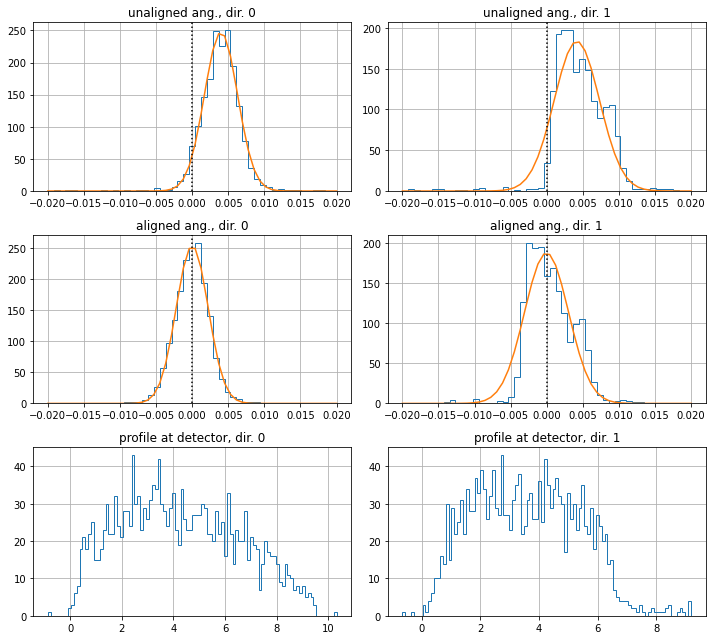

In [7]:
# beam angles and profile at chosen detector

if True:
    xplot = np.linspace(-0.02, 0.02, 50)  # binning for angle plots

    fig = plt.figure(figsize=(10, 9))
    
    for i in range(2):
        
        # unaligned angles
        ax = fig.add_subplot(321+i)
        ax.grid(True)
        ax.set_title("unaligned ang., dir. %d"%i)
        hist = plt.hist(data["thInRaw%d"%i], bins=xplot, histtype="step") ;
        xfit, yfit = hist[1][:-1]+0.5*(hist[1][1]-hist[1][0]), hist[0]
        par, _ = curve_fit(sl.fGaus, xfit, yfit, p0=(max(yfit), xfit[yfit==max(yfit)][0], 0.1))
        plt.plot(xplot, sl.fGaus(xplot, *par))
        plt.axvline(0, c="k", ls=":")
        print("before centering: center along %d is @ %f" % (i, par[1]))

        # aligned angles
        ax = fig.add_subplot(323+i)
        ax.grid(True)
        ax.set_title("aligned ang., dir. %d"%i)
        hist = plt.hist(data["thIn%d"%i], bins=xplot, histtype="step") ;
        xfit, yfit = hist[1][:-1]+0.5*(hist[1][1]-hist[1][0]), hist[0]
        par, _ = curve_fit(sl.fGaus, xfit, yfit, p0=(max(yfit), xfit[yfit==max(yfit)][0], 0.1))
        plt.plot(xplot, sl.fGaus(xplot, *par))
        plt.axvline(0, c="k", ls=":")
        print("after centering: center along %d is @ %f" % (i, par[1]))

        # aligned beam profiles at chosen detector
        ax = fig.add_subplot(325+i)
        ax.grid(True)
        ax.set_title("profile at detector, dir. %d"%i)
        plt.hist(data["x%s%d" % (var0, i)], bins=100, histtype="step") ;
    
    fig.tight_layout()

CPU times: user 14.6 s, sys: 326 ms, total: 15 s
Wall time: 14.7 s


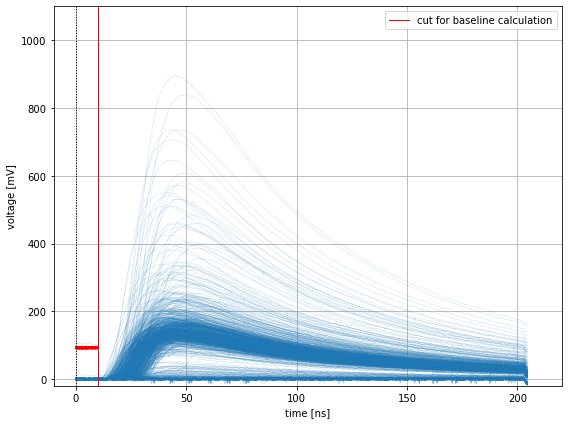

In [14]:
%%time

# single-channel waveform processing

brandpeak = True  # if True (False) a random one among the (the minimum of the) identical global maxima is selected 

bplwf = True  # plot the waveforms?

if bplwf:
    bplsingle = lambda i, wf : (True if (i%1==0) else False) & (max(wf)<wf_info[var0]["upperLimWfVis"])
    
ph = []
tp = []
bs = []
qt = []

if bplwf:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(True)

for i, y0 in enumerate(data["wave"+str(ind_wave[var0])]):
    var = var0 + "_BaseSub"
    y = data["wave"+str(ind_wave[var])][i]
    x = x_wf[var0]
    base = np.mean(data["wave"+str(ind_wave[var0+"_Base"])])
    
    ph.append(np.max(y))
    xmaxs = x[y==np.max(y)]
    tp.append(xmaxs[randint(0, len(xmaxs)-1)] if brandpeak else np.min(xmaxs))
    bs.append(base)
    qt.append(((x[1]-x[0])/rterm)*sum(y))
    
    if (bplwf & bplsingle(i, y)):
        ax.plot(x[0: wf_info[var0]["nBinsBase"]], y0[0: wf_info[var0]["nBinsBase"]], color="red", lw=0.1)
        ax.plot(x, y, color="C0", lw=0.1)
        
if bplwf:
    ax.axvline(0, color="k", lw=1, ls=":")
    ax.axvline(x[wf_info[var0]["nBinsBase"]], color="red", lw=1, label="cut for baseline calculation")
    ax.set_xlabel("time [%s]" % ("ns" if wf_info[vartemp]["bDigiTimeCalib"] else "ticks"))
    ax.set_ylabel("voltage [%s]" % ("mV" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC"))
    ax.set_xlim((pllims[0], pllims[1]))
    ax.set_ylim((pllims[2], pllims[3]))
    ax.legend()
    fig.tight_layout()
    
ph = np.array(ph)
tp = np.array(tp)
bs = np.array(bs)
qt = np.array(qt)

sel_sig = (tp>timecut_sig[0]) & (tp<timecut_sig[1]) & (ph>phcut_sig[0]) & (ph<phcut_sig[1])
sel_bkg = (tp>timecut_bkg[0]) & (tp<timecut_bkg[1]) & (ph>phcut_bkg[0]) & (ph<phcut_bkg[1])

CPU times: user 5.05 s, sys: 438 ms, total: 5.49 s
Wall time: 5.04 s


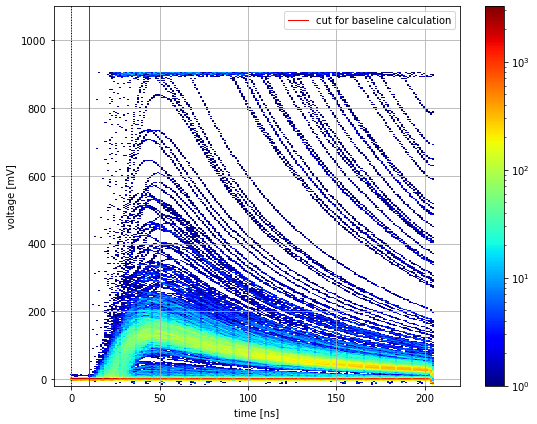

In [9]:
%%time

# single-channel waveform processing, simply for display in histogram form

if True:  # plot the waveforms in 2d-histogram form?
    
    descFact = 2  # rebinning factor
    
    xfl = np.array([])
    yfl = np.array([])
    
    fig, ax = plt.subplots(figsize=(8, 6))

    for i, y in enumerate(data["wave"+str(ind_wave[var0+"_BaseSub"])]):
        x = x_wf[var0]
        xfl = np.concatenate((xfl, np.array(x[::descFact])))
        yfl = np.concatenate((yfl, np.array(y[::descFact])))

    ax.axvline(0, color="k", lw=1, ls=":")
    ax.axvline(x[wf_info[var0]["nBinsBase"]], color="red", lw=1, label="cut for baseline calculation")
    bins = (np.arange(pllims[0], pllims[1], (pllims[1]-pllims[0])/400*descFact), 400)
    hist = ax.hist2d(xfl, yfl, bins=bins, cmin=1, cmap="jet", norm=LogNorm())
    fig.colorbar(hist[3], ax=ax)
    ax.grid(True)
    ax.set_xlim((pllims[0], pllims[1]))
    ax.set_ylim((pllims[2], pllims[3]))
    ax.set_xlabel("time [%s]" % ("ns" if wf_info[vartemp]["bDigiTimeCalib"] else "ticks"))
    ax.set_ylabel("voltage [%s]" % ("mV" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC"))
    ax.legend()
    fig.tight_layout()

In [10]:
def drawbox(limsx, limsy):
    box = (
        (limsx[0], limsx[0], limsx[1], limsx[1], limsx[0]),
        (limsy[0], limsy[1], limsy[1], limsy[0], limsy[0])
    )
    return box[0], box[1]

    nbins_ph = 150  # nr. of bins in PH plots
    nbins_tp = 100  # nr. of bins in time peak plots
    nbins_qt = 200  # nr. of bins in charge plots
    phSigmaToMeanMult = 1  # for PH fit: factor to calculate width initial parameter from the mean one
    qtSigmaToMeanMult = 2  # for charge fit: factor to calculate width initial parameter from the mean one

PH spectrum after pedestal subtraction:
[  0.     0.    -0.16 -28.88  13.    10.     4.     8.     3.     3.
   0.     1.     4.     7.    10.    10.    24.    33.    54.    80.
  84.    87.    71.    62.    52.    34.    30.    13.    15.    13.
  10.     8.     3.     9.    11.     5.     6.     3.     0.     3.
   2.     2.     3.     2.     3.     1.     1.     4.     2.     0.
   1.     0.     0.     1.     1.     2.     2.     0.     0.     1.
   0.     1.     1.     2.     1.     0.     1.     0.     0.     0.
   2.     0.     0.     2.     1.     1.     0.     0.     1.     0.
   1.     0.     0.     1.     0.     0.     0.     0.     1.     0.
   0.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   2.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.     0.     0.
   0.     1.     1.    11.28   0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.  

/eos/user/m/msoldani/.local/lib/python3.9/site-packages/succolib/math_tools/landau.py:13: RuntimeWarning: overflow encountered in exp
  expo1 = np.exp(-expo0)


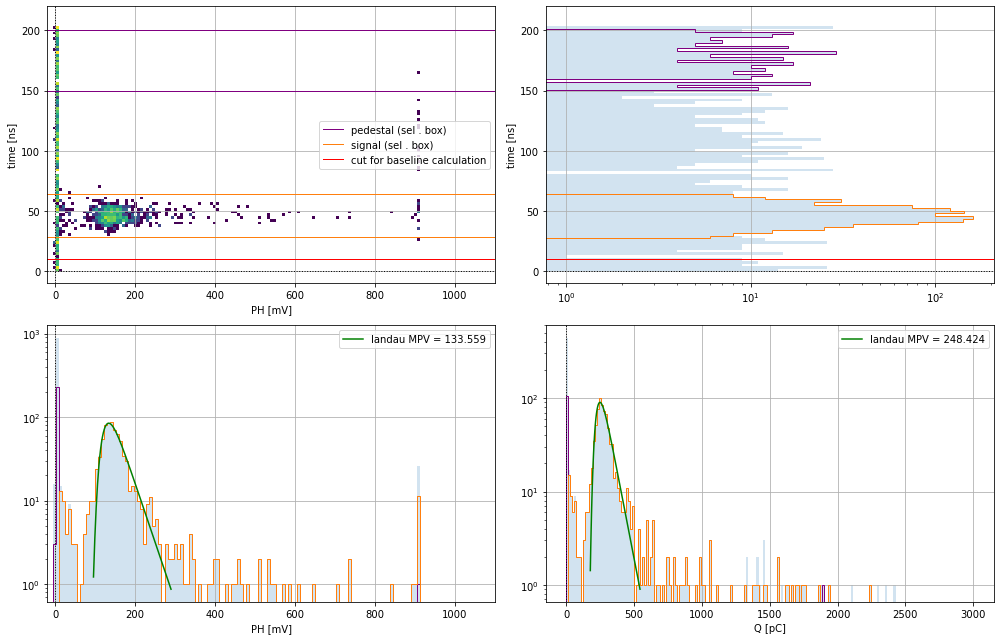

In [36]:
# aggregate distributions

if True:

    fig, axs = plt.subplots(figsize=(14, 9), nrows=2, ncols=2)

    ax = axs[0, 0]
    ax.hist2d(ph, tp, bins=(np.linspace(pllims[2], pllims[3], nbins_ph), np.linspace(pllims[0], pllims[1], nbins_tp)), norm=LogNorm());
    ax.plot(drawbox(phcut_bkg, timecut_bkg)[0], drawbox(phcut_bkg, timecut_bkg)[1], label="pedestal (sel . box)", color="purple", lw=1)
    ax.plot(drawbox(phcut_sig, timecut_sig)[0], drawbox(phcut_sig, timecut_sig)[1], label="signal (sel . box)", color="C1", lw=1)
    ax.axvline(0, color="k", lw=1, ls=":")
    ax.axhline(0, color="k", lw=1, ls=":")
    ax.axhline(x[wf_info[var0]["nBinsBase"]], color="red", lw=1, label="cut for baseline calculation")
    ax.set_ylim((pllims[0], pllims[1]))
    ax.set_xlim((pllims[2], pllims[3]))
    ax.grid(True)
    ax.set_ylabel("time [%s]" % ("ns" if wf_info[vartemp]["bDigiTimeCalib"] else "ticks"))
    ax.set_xlabel("PH [%s]" % ("mV" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC"))
    ax.legend()
    
    ax = axs[0, 1]
    ax.hist(tp, bins=np.linspace(pllims[0], pllims[1], nbins_tp), alpha=0.2, color="C0", orientation="horizontal");
    ax.hist(tp[sel_bkg], bins=np.linspace(pllims[0], pllims[1], nbins_tp), histtype="step", color="purple", orientation="horizontal");
    ax.hist(tp[sel_sig], bins=np.linspace(pllims[0], pllims[1], nbins_tp), histtype="step", color="C1", orientation="horizontal");
    ax.axhline(0, color="k", lw=1, ls=":")
    ax.axhline(x[wf_info[var0]["nBinsBase"]], color="red", lw=1, label="cut for baseline calculation")
    ax.set_ylim((pllims[0], pllims[1]))
    ax.set_xscale("log")
    ax.grid(True)
    ax.set_ylabel("time [%s]" % ("ns" if wf_info[vartemp]["bDigiTimeCalib"] else "ticks"))

    ax = axs[1, 0]
    ax.hist(ph, bins=np.linspace(pllims[2], pllims[3], nbins_ph), alpha=0.2, color="C0");
    histpede = ax.hist(ph[sel_bkg], bins=np.linspace(pllims[2], pllims[3], nbins_ph), histtype="step", color="purple");
    pede = histpede[0] * (timecut_sig[1]-timecut_sig[0])/(timecut_bkg[1]-timecut_bkg[0])
    histfit = np.histogram(ph[sel_sig], bins=np.linspace(pllims[2], pllims[3], nbins_ph));
    histfit = (histfit[0] - pede, histfit[1])
    xpl, ypl = histfit[1][:-1]+0.5*(histfit[1][1]-histfit[1][0]), histfit[0]
    ax.step(xpl, ypl, color="C1", where="mid", lw=1)
    ax.axvline(0, color="k", lw=1, ls=":")
    ax.set_xlim((pllims[2], pllims[3]))
    ax.set_yscale("log")
    ax.grid(True)
    ax.set_xlabel("PH [%s]" % ("mV" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC"))
    
    print("PH spectrum after pedestal subtraction:")
    print(histfit[0])
    
    func = sl.fLandau
    par = (max(ypl), xpl[ypl==max(ypl)][0], xpl[ypl==max(ypl)][0]*phSigmaToMeanMult)
    par, _ = curve_fit(func, xpl, ypl, p0=par)
    xplfit = np.linspace(pllims[2], pllims[3], 1000)
    yplfit = func(xplfit, *par)
    ax.plot(xplfit[yplfit>0.01*np.max(yplfit)], yplfit[yplfit>0.01*np.max(yplfit)], label="landau MPV = %.3f" % par[1], color="green")
    ax.legend()
    
    ax = axs[1, 1]
    ax.hist(qt, bins=np.linspace(qtpllims[0], qtpllims[1], nbins_qt), alpha=0.2, color="C0");
    histpede = ax.hist(qt[sel_bkg], bins=np.linspace(qtpllims[0], qtpllims[1], nbins_qt), histtype="step", color="purple");
    pede = histpede[0] * (timecut_sig[1]-timecut_sig[0])/(timecut_bkg[1]-timecut_bkg[0])
    histfit = np.histogram(qt[sel_sig], bins=np.linspace(qtpllims[0], qtpllims[1], nbins_qt));
    histfit = (histfit[0] - pede, histfit[1])
    xpl, ypl = histfit[1][:-1]+0.5*(histfit[1][1]-histfit[1][0]), histfit[0]
    ax.step(xpl, ypl, color="C1", where="mid", lw=1)
    ax.axvline(0, color="k", lw=1, ls=":")
    #ax.set_xlim((pllims[2], pllims[3]))
    ax.set_yscale("log")
    ax.grid(True)
    ax.set_xlabel("Q [%s]" % ("pC" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC*ticks"))
    
    print("Q spectrum after pedestal subtraction:")
    print(histfit[0])

    func = sl.fLandau
    par = (max(ypl), xpl[ypl==max(ypl)][0], xpl[ypl==max(ypl)][0]*qtSigmaToMeanMult)
    par, _ = curve_fit(func, xpl, ypl, p0=par)
    xplfit = np.linspace(qtpllims[0], qtpllims[1], 1000)
    yplfit = func(xplfit, *par)
    ax.plot(xplfit[yplfit>0.01*np.max(yplfit)], yplfit[yplfit>0.01*np.max(yplfit)], label="landau MPV = %.3f" % par[1], color="green")
    ax.legend()
    
    fig.tight_layout()

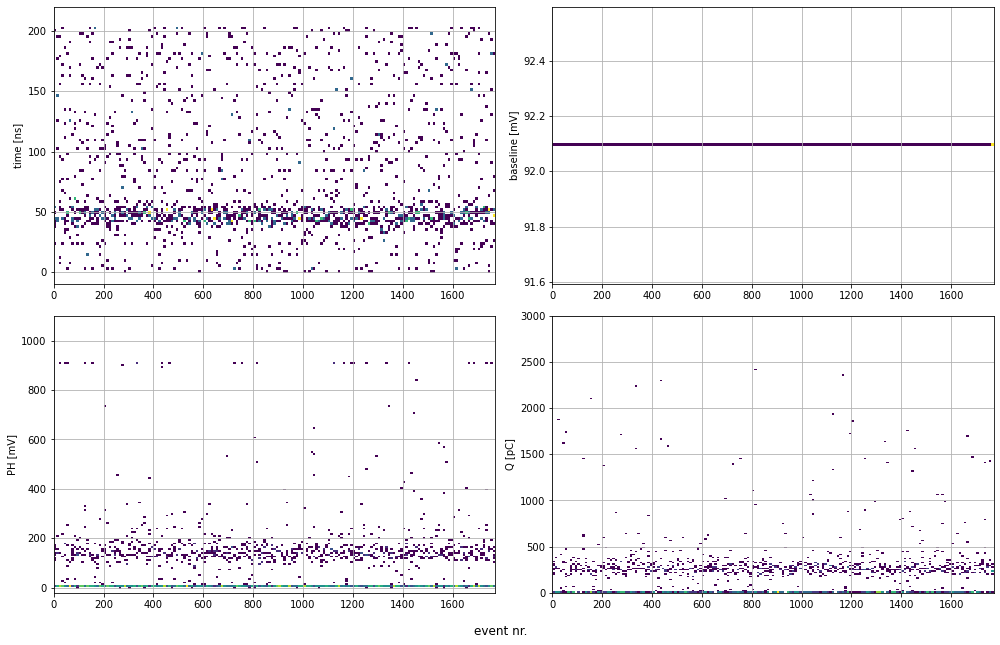

In [43]:
# distributions over time

if True:

    blog = False
    nbins_iev = 10

    fig, axs = plt.subplots(figsize=(14, 9), nrows=2, ncols=2)

    xtrend = np.array([i for i in range(len(tp))])

    ax = axs[0, 0]
    ax.set_ylabel("time [%s]" % ("ns" if wf_info[vartemp]["bDigiTimeCalib"] else "ticks"))
    bins = (np.arange(0, len(xtrend), nbins_iev), np.linspace(pllims[0], pllims[1], nbins_tp))
    ytrend = tp
    ax.hist2d(xtrend, ytrend, bins=bins, cmin=1, norm=LogNorm() if blog else None) ;

    ax = axs[0, 1]
    ax.set_ylabel("baseline [%s]" % ("mV" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC"))
    bins = (np.arange(0, len(xtrend), nbins_iev), 100)
    ytrend = bs
    ax.hist2d(xtrend, ytrend, bins=bins, cmin=1, norm=LogNorm() if blog else None) ;

    ax = axs[1, 0]
    ax.set_ylabel("PH [%s]" % ("mV" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC"))
    bins = (np.arange(0, len(xtrend), nbins_iev), np.linspace(pllims[2], pllims[3], nbins_ph))
    ytrend = ph
    ax.hist2d(xtrend, ytrend, bins=bins, cmin=1, norm=LogNorm() if blog else None) ;

    ax = axs[1, 1]
    ax.set_ylabel("Q [%s]" % ("pC" if wf_info[vartemp]["bDigiSignalCalib"] else "ADC"))
    bins = (np.arange(0, len(xtrend), nbins_iev), np.linspace(qtpllims[0], qtpllims[1], nbins_qt))
    ytrend = qt
    ax.hist2d(xtrend, ytrend, bins=bins, cmin=1, norm=LogNorm() if blog else None) ;

    fig.supxlabel("event nr.")
    for axx in axs:
        for ax in axx:
            ax.grid(True)

    fig.tight_layout()